# IA Agent.
---
En este notebook se desarrolla un agente de Q-Learning que aprende a escapar de un pequeño laberinto. Para ello, se diseña un pequeño grid que recrea el puzzle de donde debe escapar, el cual incorpora una meta y un punto de "game over". Adicionalmente, se explora el diseño, testeo y optimización de políticas del agente. Para lograr el objetivo anterior, se definen algunas de las variables del agente de Q-Learning:

**1. Ambiente:** El ambiente corresponde al laberinto en donde se encuentra el agente. Este laberinto consistirá en un grid de tamaño 4x3, el cual incorporá un punto de llegada y un punto de "game over". Adicionalmente, una de las casillas del grid será innacesible (o lo que es lo mismo, tendrá un muro).

**2. Estados:** Los estados del agente corresponderán a la posición (coordenadas) en donde se encuentre. Por ejemplo, el estado del agente en el momento $t$ es $S_{t} = (1, 2)$.

**3. Acciones:** Las acciones que puede tomar el agente son: Arriba ($up$), Abajo ($down$), Derecha ($right$), Izquierda ($left$). En caso en que el agente se "estrelle con un muro", el robot vuelve al estado en donde estaba.

**4. Recompensas:** Para el caso del agente en el laberinto, se incluirá una "penalidad de vida", es decir, cada vez que el agente tome una acción, recibirá una recompensa constante $r$. Si llega a la meta, recibirá una recompensa $R_{win}$ y se pierde $R_{loss}$

In [2]:
# Import libraries.
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import time
import random
from IPython.display import clear_output

%matplotlib inline

In [3]:
class GridEnvironment():
    
    def __init__(self):
        
        self.rw = -1 # Living (Movement) Penalty
        self.walls_and_paths = [[1, 1, 1, 1, 1], [0, 1, 0, 0, 1], [1, 1, 1, 1, 1], [1, 0, 1, 1, 1], [1, 1, 1, 1, 1]]
        self.rewards = [[0, self.rw, self.rw, self.rw, self.rw], [self.rw, self.rw, self.rw, self.rw, self.rw], [self.rw, self.rw, self.rw, self.rw, self.rw], [self.rw, self.rw, self.rw, self.rw, self.rw], [self.rw, self.rw, self.rw, self.rw, self.rw]]
        self.grid_pos = [0.1, 0.3, 0.5, 0.7, 0.9]
        self.value_state_table = [[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 10, -2]]
        self.actions = ["up", "down", "left", "right"]
        
    def newState(self, pos, action):
        
        # New position array.
        new_position = pos
        
        # Compute new position based on action taken.
        if(action == "up" and pos[1] < 4):
            if(self.walls_and_paths[pos[0]][pos[1] + 1]) == 1:
                new_position = [pos[0], pos[1] + 1]

        elif(action == "down" and pos[1] > 0):
            if(self.walls_and_paths[pos[0]][pos[1] - 1]) == 1:
                new_position = [pos[0], pos[1] - 1]

        elif(action == "left" and pos[0] > 0):
            if(self.walls_and_paths[pos[0] - 1][pos[1]]) == 1:
                new_position = [pos[0] - 1, pos[1]]

        elif(action == "right" and pos[0] < 4):
            if(self.walls_and_paths[pos[0] + 1][pos[1]]) == 1:
                new_position = [pos[0] + 1, pos[1]]
        return new_position

    
    def getStateValue(self, position):
        return self.value_state_table[position[0]][position[1]]
        
    def valueFunction(self, agent):
        
        # Initialize variable.
        new_state_value = 0
    
        # Evaluate each action.
        for action in agent.available_actions:
            
            new_state = self.newState(agent.pos, action)
            expected_return = (self.rewards[agent.pos[0]][agent.pos[1]] 
                                + agent.discount_factor * self.value_state_table[new_state[0]][new_state[1]])
            new_state_value += expected_return * agent.policy[agent.available_actions.index(action)]
            
        return new_state_value
    
    def updateValueStateTable(self, agent):
        current_state_value = self.getStateValue(agent.pos)
        new_state_value = self.valueFunction(agent)
        self.value_state_table[agent.pos[0]][agent.pos[1]] = new_state_value

In [4]:
class GridWorld():
    
    def __init__(self):
        
        self.environment = GridEnvironment()
        self.agent = valueBasedAgent(self.environment)
        print("GridWorld Initialize!")
        
        
    def render(self, x, y):
            
        fig1 = plt.figure(figsize=(4, 4))
        ax1 = fig1.add_subplot(111, aspect='equal')

        # Horizontal lines.
        for i in range(0, 6):
            ax1.axhline(i * 0.2, linewidth=2, color="#2D2D33")
            ax1.axvline(i * 0.2, linewidth=2, color="#2D2D33")

        # Salida, Meta & GameOver.
        ax1.add_patch(patches.Rectangle((0.0, 0.0), 0.2, 0.2, facecolor = "#F6D924"))
        ax1.add_patch(patches.Rectangle((0.8, 0.6), 0.2, 0.2, facecolor = "#68FF33"))
        ax1.add_patch(patches.Rectangle((0.8, 0.8), 0.2, 0.2, facecolor = "#FF5533"))

        # Muros del juego.
        ax1.add_patch(patches.Rectangle((0.2, 0.4), 0.2, 0.4, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        ax1.add_patch(patches.Rectangle((0.2, 0.0), 0.2, 0.2, facecolor = "#33A4FF"))
        #ax1.add_patch(patches.Rectangle((0.8, 0.2), 0.2, 0.2, facecolor = "#33A4FF"))
        #ax1.add_patch(patches.Rectangle((0.4, 0.8), 0.2, 0.2, facecolor = "#33A4FF"))

        # Limit grid view.
        plt.ylim((0, 1))
        plt.xlim((0, 1))

        # Plot text reward.
        pos_correct = -.02
        #plt.text(0.9 + pos_correct, 0.9 + pos_correct, "1", fontsize=16)
        #plt.text(0.9 + pos_correct, 0.7 + pos_correct, "-1", fontsize=16)
        plt.scatter(x, y, s = 100, color = "black", marker = "o", facecolor = "blue", edgecolors = "blue", zorder = 10)

        # Plot state values.
        for i in range(0, len(self.environment.value_state_table)):
            for j in range(0, len(self.environment.value_state_table[0])):
                plt.text(self.environment.grid_pos[i] - 0.08, self.environment.grid_pos[j] - 0.03, 
                         round(self.environment.value_state_table[i][j], 2), fontsize=16)
                
        # Plot grid.
        plt.axis("off")
        plt.show()    
        
    def update(self):
        self.dynamicProgrammingMethod(sigma = 2)
        
    # Method 1. No logic.
    def reachTheEnd():
        pos = self.agent.getPosition()
        while not ((self.agent.pos[0] == 4 and self.agent.pos[1] == 4) or (self.agent.pos[0] == 4 and self.agent.pos[1] == 3)):
            self.agent.move()
            pos = self.agent.getPosition()
            grid_coords = self.environment.grid_pos
            self.render(grid_coords[pos[0]], grid_coords[pos[1]])
            
            time.sleep(0.1)
            clear_output(wait = True)
            
    # Method 2. Dynamic Programming Method.
    def dynamicProgrammingMethod(self, sigma):
        
        delta = 0 
        counter = 0
        #while(delta < sigma):
        while(counter < 1000):
            counter += 1
            # Dyamic Programming Algorithm
            delta = 0
            current_state_value = self.environment.getStateValue(self.agent.getPosition())
            self.agent.move()
            new_state_value = self.environment.getStateValue(self.agent.getPosition())
            delta = max(delta, abs(current_state_value - new_state_value))
            print(delta)
            
            # Draw grid and agent.
            pos = self.agent.getPosition()
            grid_coords = self.environment.grid_pos
            print("Step: ", counter)
            
            self.render(grid_coords[pos[0]], grid_coords[pos[1]])
            time.sleep(0.1)
            clear_output(wait = True)

## Value Based Agent.

In [5]:
class valueBasedAgent():
    
    def __init__(self, environment):
        self.pos = [0,0]
        self.total_reward = 0
        self.environment = environment
        self.available_actions = self.environment.actions
        self.mode = mode
        
        self.policy = [0.25, 0.25, 0.25, 0.25]
        self.discount_factor = 0.5
        
    def selectAction(self):
        action = self.available_actions[random.randint(0, len(self.available_actions) - 1)] # Agent initial policy.
        return action
        
    def move(self):
    
        # Select action according to policy.
        action = self.selectAction()
        print("Action taken", action)

        # Move to new position according to action taken.
        self.pos = self.environment.newState(self.pos, action)
        print("New Position: ", self.pos)
                        
        if (self.pos[0] == 4 and self.pos[1] == 4) or (self.pos[0] == 4 and self.pos[1] == 3):
            self.pos[0] = 0
            self.pos[1] = 0
            print("One epoch completed!")
        else:
            # Update value state table.
            self.environment.updateValueStateTable(self)
        
    def getPosition(self):
        return self.pos
    
    def getReward(self):
        return self.total_reward

### Policy Evaluation (Prediction).

Action taken left
New Position:  [2, 3]
1.9531209383139014e-07
Step:  1000


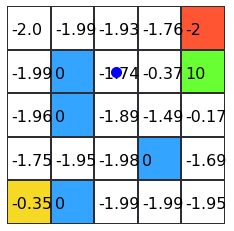

In [6]:
# Play game!.
world = GridWorld()
world.update()

### Policy Improvement (Control).

In [9]:
world.environment.value_state_table

[[-0.3503528412325395,
  -1.7517642135801104,
  -1.9573476188448478,
  -1.9923215228451208,
  -1.9965815303368624],
 [0, -1.9547097200027927, 0, 0, -1.9871676656599506],
 [-1.9943949007496846,
  -1.9765405073766944,
  -1.8867313112664057,
  -1.7409427960997774,
  -1.926425461538506],
 [-1.9899939192565346,
  0,
  -1.4897021058487656,
  -0.3734429952056235,
  -1.7570216941842245],
 [-1.9459141636147677, -1.685632905642056, -0.1679031392993791, 10, -2]]

In [ ]:
    # Method 1. No logic.
    def reachTheEnd():
        pos = self.agent.getPosition()
        while not ((self.agent.pos[0] == 4 and self.agent.pos[1] == 4) or (self.agent.pos[0] == 4 and self.agent.pos[1] == 3)):
            self.agent.move()
            pos = self.agent.getPosition()
            grid_coords = self.environment.grid_pos
            self.render(grid_coords[pos[0]], grid_coords[pos[1]])
            
            time.sleep(0.1)
            clear_output(wait = True)
          
    # Method 2. Dynamic Programming Method.
    def dynamicProgrammingMethod2(self, sigma):
        
        delta = 0 
        counter = 0
        #while(delta < sigma):
        while(counter < 1000):
            counter += 1
            # Dyamic Programming Algorithm
            delta = 0
            current_state_value = self.environment.getStateValue(self.agent.getPosition())
            self.agent.move()
            new_state_value = self.environment.getStateValue(self.agent.getPosition())
            delta = max(delta, abs(current_state_value - new_state_value))
            print(delta)
            
            # Draw grid and agent.
            pos = self.agent.getPosition()
            grid_coords = self.environment.grid_pos
            print("Step: ", counter)
            
            self.render(grid_coords[pos[0]], grid_coords[pos[1]])
            time.sleep(0.1)
            clear_output(wait = True)